In [34]:
rdd = sc.textFile('2015_07_22_mktplace_shop_web_log_sample.log')
rdd = rdd.map(lambda line: line.split(" "))

from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

rdd = rdd.map(lambda line: Row(timestamp=line[0], ipaddress=line[2].split(':')[0],url=line[12]))


In [35]:
mainDF = rdd.toDF()

In [36]:
mainDF.show(50)

+---------------+--------------------+--------------------+
|      ipaddress|           timestamp|                 url|
+---------------+--------------------+--------------------+
|123.242.248.130|2015-07-22T09:00:...|https://paytm.com...|
|  203.91.211.44|2015-07-22T09:00:...|https://paytm.com...|
|    1.39.32.179|2015-07-22T09:00:...|https://paytm.com...|
| 180.179.213.94|2015-07-22T09:00:...|https://paytm.com...|
| 120.59.192.208|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  101.60.186.26|2015-07-22T09:00:...|https://paytm.com...|
|   59.183.41.47|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  183.83.237.83|2015-07-22T09:00:...|https://paytm.com...|
|  117.195.91.36|2015-07-22T09:00:...|https://paytm.com...|
|122.180.245.251|2015-07-22T09:00:...|https://paytm.com...|
| 117.198.215.20|2015-07-22T09:00:...|https://paytm.com...|
| 223.176.154.91|2015-07-22T09:00:...|ht

In [37]:
mainDF = mainDF.withColumn('timestamp', mainDF['timestamp'].cast(TimestampType()))

In [38]:
loadperMinDF = mainDF.select(window("timestamp", "60 seconds").alias('timewindow'),'timestamp',"ipaddress").groupBy('timewindow').count().withColumnRenamed('count', 'HitperMin')

In [60]:
loadperMinPandasDf = loadperMinDF.sort("timewindow.start").toPandas()

In [61]:
loadperMinPandasDf.index = [s[0] for s in loadperMinPandasDf['timewindow']]

In [62]:
loadperMinPandasDf.drop(['timewindow'],1,inplace=True)

In [129]:
loadperMinFilled = loadperMinPandasDf.asfreq('min').fillna(0)

In [125]:
loadperMinFilled.to_csv("HitPerMin.csv")

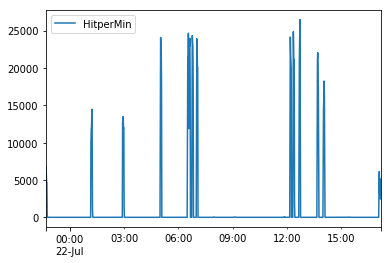

In [130]:
import matplotlib.pyplot as plt 
plt.figure()
loadperMinFilled.plot()
plt.show()

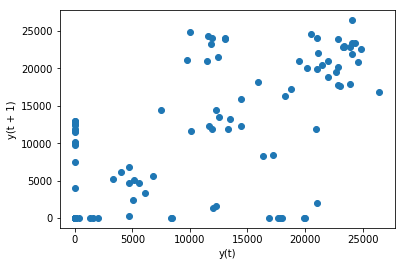

In [131]:
from pandas.tools.plotting import lag_plot
lag_plot(loadperMinFilled)
plt.show()

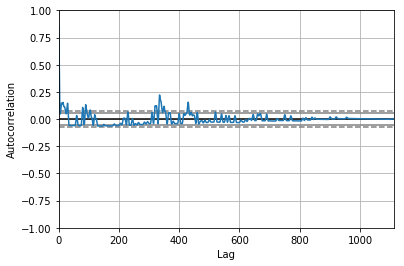

In [132]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(loadperMinFilled)
plt.show()

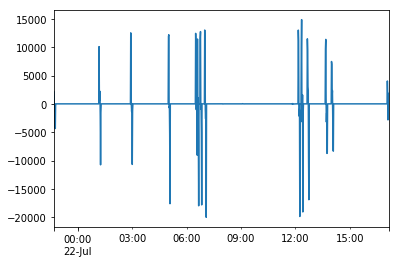

In [133]:
loadperMinFilled['HitperMin'].diff().dropna().plot()
plt.show()

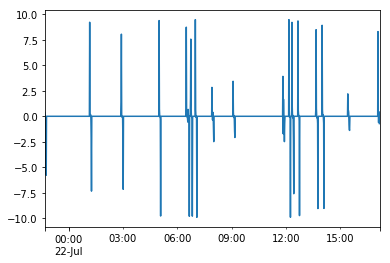

In [138]:
#taking sqrt transform then differencing, still can't make the time series stationary
loadperMinFilled['#HitperMin_log'] = np.sqrt(loadperMinFilled['HitperMin'])
loadperMinFilled['#HitperMin_log_diff'] = loadperMinFilled['#HitperMin_log'].diff()
loadperMinFilled['#HitperMin_log_diff'].dropna().plot()
plt.show()